# 10-5-3 Decay Network
This notebook generates a toy dataset of 10-D vectors that are from 3 different clusters (3 classes). The network is trained to classify the vectors. We train 2 models, one without decay, and one with decay.

Three different models are tested: **untrained**, trained **without weight decay**, and trained **with weigth decay**.

Each of those models is used to generate samples, one of each class. They are done using two methods: **without value-node decay**, and **with value-node decay**.

## Preliminaries

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

dtype = torch.float
device = torch.device("cpu")
#device = torch.device("mps")
#device = torch.device("cuda:0") # Uncomment this to run on GPU
import NeuralNetwork as NN
#import FFNetwork as FF
import Layer
import time
from IPython.display import display
from ipywidgets import FloatProgress
from copy import deepcopy

%load_ext autoreload
%autoreload 2

In [2]:
def ClassPlot(x, labels=[], idx=(1,2), equal=True):
    '''
     ClassPlot(x, labels=[], idx=(1,2), equal=True)
     Plots the dataset, with coord idx[0] vs idx[1].
     
     Inputs:
      x       array of points to plot
      labels  array of class labels
      idx     plot idx[0] vs idx[1]
      equal   Boolean, to scale axes equally
    '''
    if len(labels)>0:
        colour_options = ['y', 'r', 'g', 'b', 'k']
        cidx = np.argmax(labels, axis=1)
        colours = [colour_options[k] for k in cidx]
        plt.scatter(x[:,idx[0]], x[:,idx[1]], color=colours, marker='.')
    else:
        plt.scatter(x[:,idx[0]], x[:,idx[1]], marker='.')
    if equal:
        plt.axis('equal');

## Create a simple dataset

In [3]:
# This creates a dataset

n_classes = 3
hidden_dim = 5
sensory_dim = 10

seed = 4896
# torch.manual_seed(seed)
# np.random.seed(seed)
B = np.eye(n_classes)
X = 3.*(np.random.rand(sensory_dim, n_classes) - 0.5)
A = X.T
print('Bottom vectors')
print(B)
print('Top vectors')
print(A)
#print('System matrix:\n'+str(M))

Bottom vectors
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Top vectors
[[-1.13660452 -0.01927459 -1.28902888  1.42739424 -0.24971673  0.81251209
  -0.34783994  1.31616616  0.75351739  1.47814223]
 [ 0.45590082  0.58294839  0.99105428 -1.08834917 -1.23687199  0.96792656
  -1.23688536 -0.6028284   0.6953495   0.44324315]
 [ 1.04277525  0.30910295 -1.3146107   0.93356968 -0.08534203 -0.54409522
   0.69294488  1.44573292  0.79183294  0.36434179]]


In [4]:
# Use A and B to make a dataset
n_classes, top_dim = np.shape(A)
bottom_dim = n_classes

training_samples = 500
noise = 0.2
training_input = []
training_output = []
for n in range(training_samples):
    r = np.random.randint(n_classes)
    training_input.append(B[r])
    training_output.append(A[r]+noise*np.random.normal(size=np.shape(A[r])))

training_input = torch.tensor(training_input).float().to(device)
training_output = torch.tensor(training_output).float().to(device)
train = [training_input, training_output]

/var/folders/97/ppgk101x3214hn7bzlb85jk00000gn/T/ipykernel_75249/225946647.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  training_input = torch.tensor(training_input).float().to(device)


In [5]:
# Use A and B to make a dataset
def MakeDataset(A, B, n=300, noise=0.2):
    n_classes, top_dim = np.shape(A)
    bottom_dim = n_classes

    training_samples = n
    #noise = 0.2
    training_input = []
    training_output = []
    for n in range(training_samples):
        r = np.random.randint(n_classes)
        training_input.append(B[r])
        training_output.append(A[r]+noise*np.random.normal(size=np.shape(A[r])))

    training_input = torch.tensor(training_input).float().to(device)
    training_output = torch.tensor(training_output).float().to(device)
    train = [training_input, training_output]
    return train

In [6]:
train = MakeDataset(A, B)

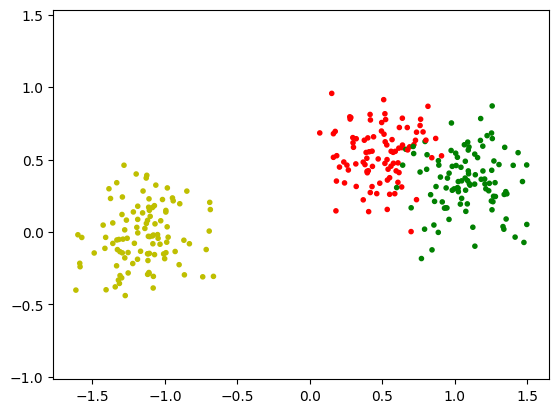

In [25]:
ClassPlot(train[1].cpu(), labels=train[0].cpu(), idx=(0,1))

In [8]:
num_classes = 3
input_dim = 10

classes = np.eye(3)
print(classes)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


# Train the models

In [9]:
from time import time

start = time()
net = NN.NeuralNetwork()
net.AddLayer(Layer.InputPELayer(n=n_classes))
net.AddLayer(Layer.PELayer(n=hidden_dim))
net.AddLayer(Layer.TopPELayer(n=sensory_dim))

sym = True
af = 'identity'
net.Connect(0, 1, act=af, symmetric=sym)
net.Connect(1, 2, act=af, symmetric=sym)

net.SetTau(0.02)
net.learning_tau = 0.1
net.learn_biases = False
net.learning_blackout=2.0

# Make two copies
net0 = deepcopy(net)
net1 = deepcopy(net)

# Train a model with no weight decay
net0.SetWeightDecay(0.0)
net0.SetvDecay(0.0)
net0.Learn(train[0], train[1], T=5., dt=0.001, epochs=10, batch_size=20)

# Train a model WITH weight decay
net1.SetWeightDecay(0.04)
net1.SetvDecay(0.0)
net1.Learn(train[0], train[1], T=5., dt=0.001, epochs=10, batch_size=20)

print(f'Total time: {time()-start}')

identity
identity


FloatProgress(value=0.0, max=3000.0)

FloatProgress(value=0.0, max=3000.0)

Total time: 305.27750420570374


# Save and/or Load the models

In [10]:
# You can save the networks
# Just uncomment the following lines
# net.Save('untrained.net')
# net0.Save('trained_no_decay.net')
# net1.Save('trained_decay.net')

In [11]:
# You can load the networks from files
# Just uncomment the following lines
# net = NN.NeuralNetwork(); net.Load('untrained.net')
# net0 = NN.NeuralNetwork(); net0.Load('trained_no_decay.net')
# net1 = NN.NeuralNetwork(); net1.Load('trained_decay.net')

# Test the Models

## Untrained model

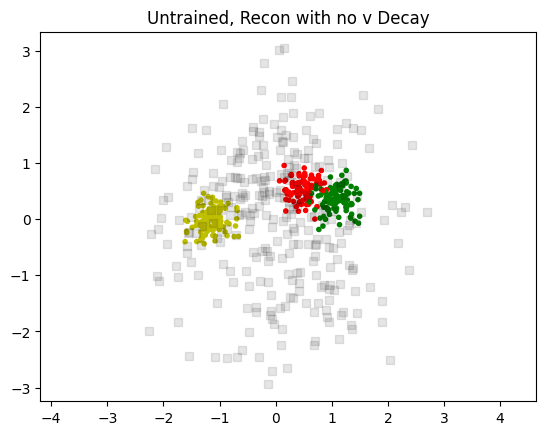

In [19]:
net.Allocate(train[0])
net.Reset(random=1.)
net.SetvDecay(0.)
z1 = net.Predict(10., train[0], dt=0.001)
idx = (0,1)
ClassPlot(train[1].cpu(), labels=train[0].cpu(), idx=idx)
plt.plot(z1[:,idx[0]].cpu(), z1[:,idx[1]].cpu(), 's', color=(0,0,0,0.1));
plt.title('Untrained, Recon with no v Decay');

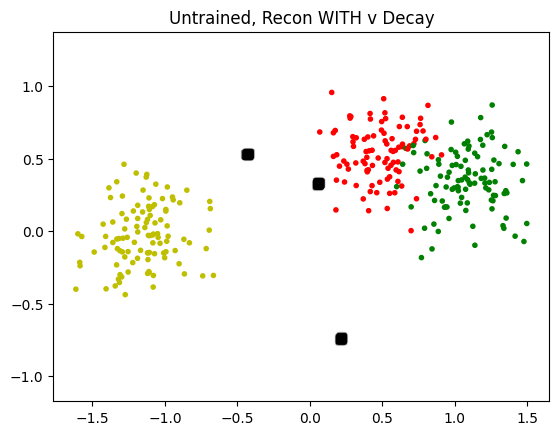

In [20]:
net.Allocate(train[0])
net.SetvDecay(0.01)
net.Reset(random=1.)
z1d = net.Predict(10., train[0], dt=0.001)
ClassPlot(train[1], labels=train[0], idx=idx)
plt.plot(z1d[:,idx[0]], z1d[:,idx[1]], 's', color=(0,0,0,0.1));
plt.title('Untrained, Recon WITH v Decay');

## Trained without weight decay

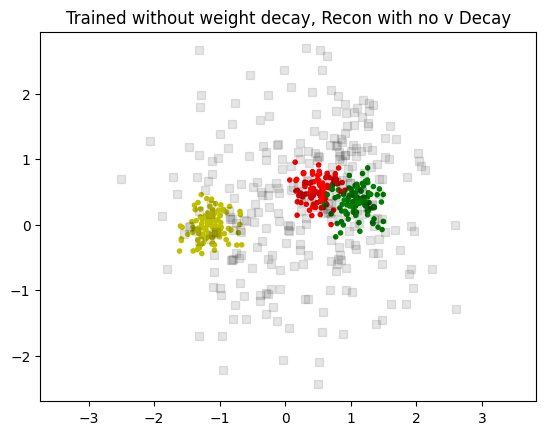

In [21]:
net0.Allocate(train[0])
net0.SetvDecay(0.)
net0.Reset(random=1.)
z2 = net0.Predict(20., train[0], dt=0.001)
ClassPlot(train[1], labels=train[0], idx=idx)
plt.plot(z2[:,idx[0]], z2[:,idx[1]], 's', color=(0,0,0,0.1));
plt.title('Trained without weight decay, Recon with no v Decay');

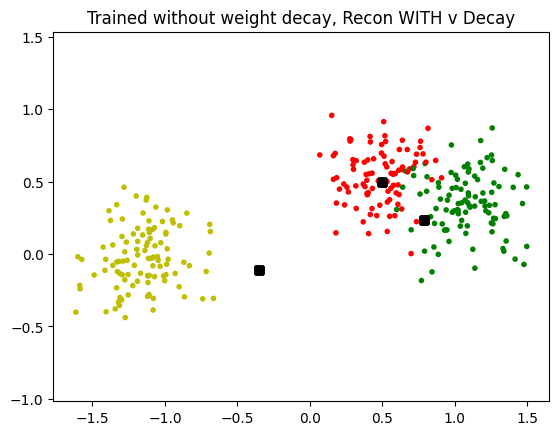

In [22]:
net0.Allocate(train[0])
net0.SetvDecay(0.01)
net0.Reset(random=1.)
z2d = net0.Predict(20., train[0], dt=0.001)
ClassPlot(train[1], labels=train[0], idx=idx)
plt.plot(z2d[:,idx[0]], z2d[:,idx[1]], 's', color=(0,0,0,0.1));
plt.title('Trained without weight decay, Recon WITH v Decay');

## Trained WITH weight decay

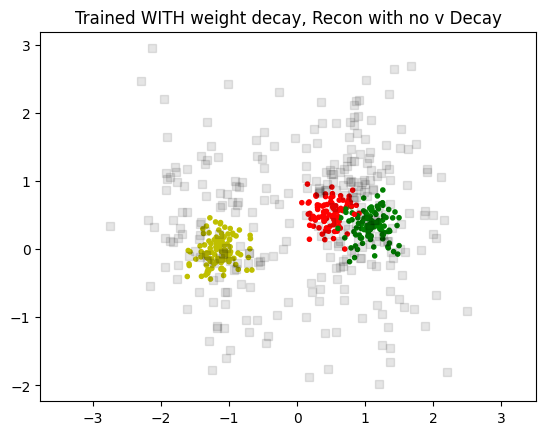

In [23]:
net1.Allocate(train[0])
net1.SetvDecay(0.)
net1.Reset(random=1.)
z3 = net1.Predict(10., train[0], dt=0.001)
ClassPlot(train[1], labels=train[0], idx=idx)
plt.plot(z3[:,idx[0]], z3[:,idx[1]], 's', color=(0,0,0,0.1));
plt.title('Trained WITH weight decay, Recon with no v Decay');

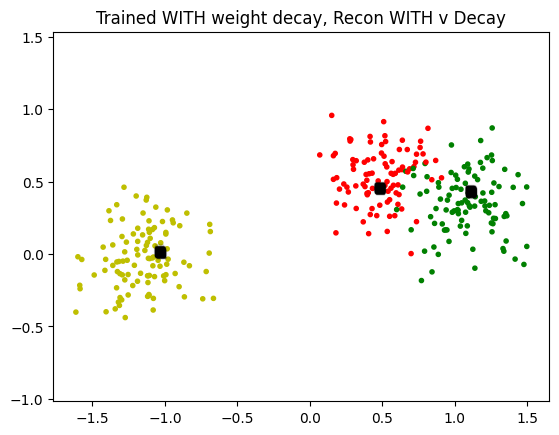

In [24]:
net1.Allocate(train[0])
net1.SetvDecay(0.01)
net1.Reset(random=1.)
z3d = net1.Predict(10., train[0], dt=0.001)
ClassPlot(train[1], labels=train[0], idx=idx)
plt.plot(z3d[:,idx[0]], z3d[:,idx[1]], 's', color=(0,0,0,0.1));
plt.title('Trained WITH weight decay, Recon WITH v Decay');